# Project work 
## Balogh Nóra, Gyulai László, Vargha Noémi

In this project we have implemented 2 dimensional Ising model with Monte-Carlo simulation. We aimed to train neural networks based on the simulation results. 
The main parts of our work:
1. Implementing Monte-Carlo simulation code for the Ising model
2. Generating training data
3. Neural Network learns to calculate energy and magnetization
4. Neural Network learns to calculate coupling strength

Ideas:

https://arxiv.org/pdf/1706.09779.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from numpy.random import rand
from numpy.random import randint

In [2]:
import random

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [4]:
from sklearn.metrics import mean_squared_error

# 1. Monte-Carlo simulation code for the Ising model


We used a square lattice od size LxL=10x10. Each cell in the square lattice has spin $\sigma_i=\pm 1$ which is initialized randomly. The Hamiltonian of the system is:

$$ H=-K\sum_{\langle i\mathrm{,}j \rangle} \sigma_i \sigma_J - h\sum_{i}\sigma_i$$
where the summation runs over the nearest neighbors, $K$ is coupling strength between the nearest neighbors and $h$ is the external field.

assiged each lattice cell a random spin of $\pm 1$ with the function below:

Parameters of the 2D Ising model: 
* hi: interaction with external field
* Kij: interactions between neighbours

In [5]:
def initialize(L):   
    ''' generates a random spin (+1 or -1) configuration for initial condition'''
    state = 2*np.random.randint(2, size=(L,L))-1
    return state #square lattice, cells filled randomly with +1 or -1

Magnetization is the average value of the spin. (Source: https://en.wikipedia.org/wiki/Ising_model). The energy of a configuration is calculated from the Hamiltonian.

In [6]:
def magnetization(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)/(config.shape[0]*config.shape[1])
    return mag

def Energy(config, h, K):
    '''Calculates energy of a given configuration'''
    energy = 0
    L=len(config)
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            energy-=h*S
            #neighbors with periodic boundary conditions
            neighbors = config[(i+1)%L, j] + config[i,(j+1)%L] + config[(i-1)%L, j] + config[i,(j-1)%L] 
            energy -= K*neighbors*S
    return energy

One Monte Carlo timestep consists of LxL elementary step in which a spin is chosen randomly and flipped according to the Metropolis probabilities. 

In each elementary step we randomly choose a lattice point with spin $s$. If the spin is flipped, the cost is $\Delta E=E_{flipped}-E_{original}$. From the Hamiltonian:

$$\Delta E= 2hs-2Ks\cdot nb$$

where $nb$ is the sum of the spins of the nearest neighbors of s. The function "mcmove" below calculates this cost and flips the spin if $\Delta E < 0$ and flips this spin with probability $p=\exp(\beta\cdot\Delta E)$ if $E>0$. ($\beta=\frac{1}{k_bT}$)

In [7]:
def mcmove(config, beta, h, K):
    '''Monte Carlo move using Metropolis algorithm '''
    L=len(config)
    for i in range(L):
        for j in range(L):
                a = np.random.randint(0, L)
                b = np.random.randint(0, L)
                s =  config[a, b]
                neighbors = config[(a+1)%L,b] + config[a,(b+1)%L] + config[(a-1)%L,b] + config[a,(b-1)%L]
                #cost=difference between energies
                cost = 2*h*s + 2*K*neighbors*s
                if cost < 0:
                    s *= -1
                elif np.random.rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config

Use Monte carlo step as: config=mcmove(config, beta, h, K)

# 2. Training data generation

## 2.1 Generation of lattices for energy and magnetization prediction

In [8]:
K=1
beta=0.2
L=10
h=5
timesteps = 500
iterations = 20
config_data=[]


for i in range(iterations):
    config=initialize(L)
    E,M=np.zeros(timesteps), np.zeros(timesteps)
    M0=np.zeros(timesteps)
    for t in range(timesteps):
        E[t]=Energy(config, h, K)
        M[t]=magnetization(config)
        row1 = [E[t]]+[M[t]]+list(config.flatten())
        config_data.append(row1)
        config=mcmove(config, beta, h, K)

In [9]:
len(config_data)

10000

We will store in a .csv file the following features of each generated lattice:
* energy
* magnetization
* config: the lattice configuration (array of +1, -1 values)

In [10]:
with open('training_data.csv', 'w+', newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(config_data)
writeFile.close()

## 2.2. Training data generation for coupling strength prediction 

In each iteration we use different coupling strength and step 10 Monte-Carlo steps (timesteps) with it. Temperature and external field values are fixed.

In [11]:
K=1
beta=0.2
L=10
h=5
timesteps = 10
iterations = 5000
config_data=[]

E,M=np.zeros(iterations), np.zeros(iterations)
#Klist=[j/1000 for j in range(iterations)]
for i in range(iterations):
    K=np.random.normal()+1  # k is a random value between 0 and 2
    config=initialize(L)
    for t in range(timesteps):
        config=mcmove(config, beta, h, K)
    E[i]=Energy(config, h, K)
    M[i]=magnetization(config)
    row1 = [K]+[E[i]]+[M[i]]+list(config.flatten())
    config_data.append(row1)

In [12]:
len(config_data)

5000

In [13]:
with open('training_data2.csv', 'w+', newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(config_data)
writeFile.close()

# 3. Neural Network learns to calculate energy and magnetization

## 3.1. Loading the data

In [14]:
traindata = pd.read_csv("training_data.csv", names=["E"]+["M"]+[i for i in range(L*L)])

In [15]:
trainlabelsE=traindata["E"].values
trainlabelsM=traindata["M"].values

In [16]:
train_attrs=traindata.drop(columns=["E", "M"])

## 3.2. Magnetization prediction

Normalization of training labels:

In [17]:
max(trainlabelsM)

1.0

In [18]:
min(trainlabelsM)

-0.22

In [19]:
trainlabelsM

array([-0.04,  0.44,  0.72, ...,  0.92,  0.96,  0.92])

In [20]:
#trainlabelsM=(trainlabelsM-(-1))/(1-(-1))
trainlabelsM=(trainlabelsM-min(trainlabelsM))/(max(trainlabelsM)-min(trainlabelsM))

Split train and test values:

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(train_attrs, trainlabelsM, test_size=0.33, random_state=0)

In [22]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6700, 100), (6700,), (3300, 100), (3300,))

Definition of the model:

In [23]:
model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 6700 samples, validate on 3300 samples
Epoch 1/100
6700/6700 [==============================] - 0s 43us/step - loss: 0.0463 - val_loss: 0.0083
Epoch 2/100
6700/6700 [==============================] - 0s 21us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 3/100
6700/6700 [==============================] - 0s 22us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/100
6700/6700 [==============================] - 0s 21us/step - loss: 7.8930e-04 - val_loss: 8.3094e-04
Epoch 5/100
6700/6700 [==============================] - 0s 21us/step - loss: 5.0175e-04 - val_loss: 6.3748e-04
Epoch 6/100
6700/6700 [==============================] - 0s 22us/step - loss: 3.5736e-04 - val_loss: 0.0010
Epoch 7/100
6700/6700 [==============================] - 0s 22us/step - loss: 2.9739e-04 - val_loss: 5.2830e-04
Epoch 8/100
6700/6700 [==============================] - 0s 21us/step - loss: 3.0750e-04 - val_loss: 8.8820e-04
Epoch 9/100
6700/6700 [=============

Making predictions and evaluation:

In [27]:
preds = model.predict(X_test)
print('MSE : ', mean_squared_error(preds, Y_test))

MSE :  0.0003063977349365151


Text(0, 0.5, 'count')

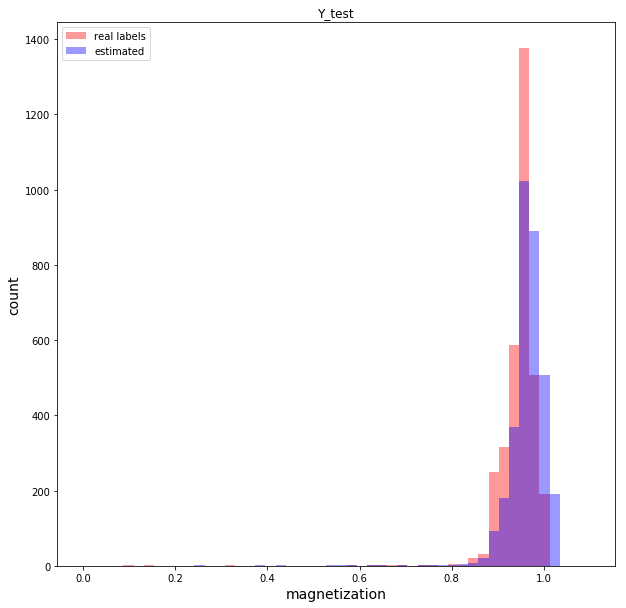

In [28]:
plt.figure(figsize=(10,10))
Y_hist = plt.hist(Y_test, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='r')
plt.title("Y_test")
pred_hist = plt.hist(preds, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='b')
plt.legend(["real labels", "estimated"], loc='upper left')
plt.xlabel("magnetization", fontsize = 14)
plt.ylabel("count",  fontsize = 14)

## 3.3 Energy prediction

Normalization of the labels:

In [29]:
max(trainlabelsE)

78.0

In [30]:
min(trainlabelsE)

-900.0

In [31]:
trainlabelsE=(trainlabelsE-min(trainlabelsE))/(max(trainlabelsE)-min(trainlabelsE))

In [32]:
min(trainlabelsE)

0.0

In [33]:
X_trainE, X_testE, Y_trainE, Y_testE = train_test_split(train_attrs, trainlabelsE, test_size=0.33, random_state=0)

Definition of the model:

In [34]:
model2 = Sequential()
model2.add(Dense(100, input_dim=100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(30, activation='relu'))
model2.add(Dense(1, activation='relu'))

In [35]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 16,711
Trainable params: 16,711
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model2.fit(x=X_trainE, y=Y_trainE, batch_size=64, epochs=100, validation_data=(X_testE, Y_testE))

Train on 6700 samples, validate on 3300 samples
Epoch 1/100
6700/6700 [==============================] - 0s 46us/step - loss: 0.0095 - val_loss: 0.0086
Epoch 2/100
6700/6700 [==============================] - 0s 15us/step - loss: 0.0096 - val_loss: 0.0086
Epoch 3/100
6700/6700 [==============================] - 0s 15us/step - loss: 0.0086 - val_loss: 0.0057
Epoch 4/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0026 - val_loss: 9.0791e-04
Epoch 5/100
6700/6700 [==============================] - 0s 16us/step - loss: 7.2906e-04 - val_loss: 6.6341e-04
Epoch 6/100
6700/6700 [==============================] - 0s 15us/step - loss: 5.1134e-04 - val_loss: 6.1371e-04
Epoch 7/100
6700/6700 [==============================] - 0s 14us/step - loss: 3.7253e-04 - val_loss: 4.8657e-04
Epoch 8/100
6700/6700 [==============================] - 0s 15us/step - loss: 3.2988e-04 - val_loss: 4.3452e-04
Epoch 9/100
6700/6700 [==============================] - 0s 15us/step - loss: 3.0934

In [38]:
predsE = model2.predict(X_testE)
print('MSE : ', mean_squared_error(predsE, Y_testE))

MSE :  0.0001104853180888348


Text(0, 0.5, 'count')

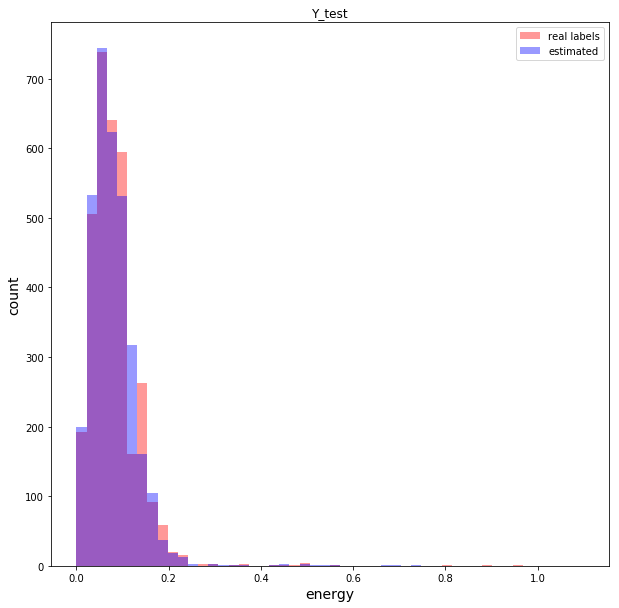

In [39]:
plt.figure(figsize=(10,10))
Y_hist = plt.hist(Y_testE, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='r')
plt.title("Y_test")
pred_hist = plt.hist(predsE, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='b')
plt.legend(["real labels", "estimated"], loc='upper right')
plt.xlabel("energy", fontsize = 14)
plt.ylabel("count",  fontsize = 14)

# 4. Neural Network learns to calculate coupling strength

In [40]:
traindata2 = pd.read_csv("training_data2.csv", names=["K"]+["E"]+["M"]+[i for i in range(L*L)])

In [41]:
traindata2.head()

,K,E,M,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,0.981545,-866.913386,0.98,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0.244548,-472.604335,0.82,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1.479373,-1058.079211,0.98,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,3.178758,-1649.783027,0.96,1,1,1,-1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0.148842,-438.103564,0.80,1,1,1,1,1,1,1,...,1,1,1,1,1,1,-1,1,1,1


In [42]:
traindata2["E"]=(traindata2["E"]-min(traindata2["E"]))/(max(traindata2["E"])-min(traindata2["E"]))

In [43]:
traindata2["M"]=(traindata2["M"]-min(traindata2["M"]))/(max(traindata2["M"])-min(traindata2["M"]))

In [44]:
trainlabelsK=traindata2["K"].values

In [45]:
train_attrs2=traindata2.drop(columns=["K"])

In [46]:
trainlabelsK=(trainlabelsK-min(trainlabelsK))/(max(trainlabelsK)-min(trainlabelsK))

In [47]:
min(trainlabelsK)

0.0

In [48]:
X_trainK, X_testK, Y_trainK, Y_testK = train_test_split(train_attrs2, trainlabelsK, test_size=0.33, random_state=0)

In [49]:
X_trainK.shape, Y_trainK.shape, X_testK.shape, Y_testK.shape

((3350, 102), (3350,), (1650, 102), (1650,))

In [50]:
model3 = Sequential()
model3.add(Dense(102, input_dim=102, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(40, activation='relu'))
model3.add(Dense(1, activation='relu'))

In [51]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 102)               10506     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10300     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 41        
Total params: 34,987
Trainable params: 34,987
Non-trainable params: 0
_________________________________________________________________


In [52]:
model3.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
history = model3.fit(x=X_trainK, y=Y_trainK, batch_size=64, epochs=100, validation_data=(X_testK, Y_testK))

Train on 3350 samples, validate on 1650 samples
Epoch 1/100
3350/3350 [==============================] - 0s 102us/step - loss: 0.0122 - val_loss: 0.0084
Epoch 2/100
3350/3350 [==============================] - 0s 21us/step - loss: 0.0058 - val_loss: 0.0054
Epoch 3/100
3350/3350 [==============================] - 0s 21us/step - loss: 0.0046 - val_loss: 0.0052
Epoch 4/100
3350/3350 [==============================] - 0s 20us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 5/100
3350/3350 [==============================] - 0s 20us/step - loss: 0.0036 - val_loss: 0.0056
Epoch 6/100
3350/3350 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0040
Epoch 7/100
3350/3350 [==============================] - 0s 19us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 8/100
3350/3350 [==============================] - 0s 21us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/100
3350/3350 [==============================] - 0s 19us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 10/100
33

In [54]:
predsK = model3.predict(X_testK)
print('MSE : ', mean_squared_error(predsK, Y_testK))

MSE :  0.001403084344643398


Text(0, 0.5, 'count')

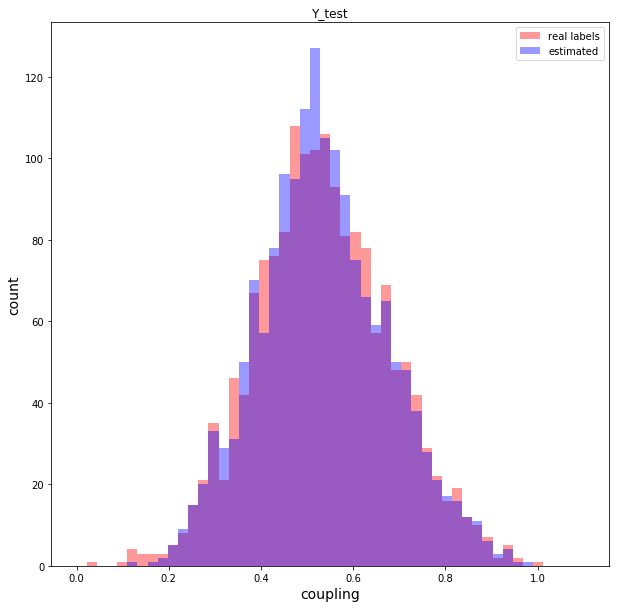

In [55]:
plt.figure(figsize=(10,10))
Y_hist = plt.hist(Y_testK, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='r')
plt.title("Y_test")
pred_hist = plt.hist(predsK, 50, (0,1.1),histtype="stepfilled",alpha= 0.4, color ='b')
plt.legend(["real labels", "estimated"], loc='upper right')
plt.xlabel("coupling", fontsize = 14)
plt.ylabel("count",  fontsize = 14)